In [1]:
%pip install seaborn
# To avoid the deprecation warning
%pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Datasets
launches = pd.read_csv('Launches.csv')
configs = pd.read_csv('Configs.csv')
families = pd.read_csv('Families.csv')
companies = pd.read_csv('Companies.csv')
locations = pd.read_csv('Locations.csv')
missions = pd.read_csv('Missions.csv')

As our dataset is split up between 6 csv files, the dataframe must combine the data from them. For that, we will use joins and, for them to work, the data types must be correctly aligned.

In [6]:
configs['Family Id'] = configs['Family Id'].astype(int)

rockets = pd.merge(configs, families, how = 'inner', on = 'Family Id')

launch_data = pd.merge(launches, locations, how = 'inner', left_on = 'Location', right_on = 'Orig_Addr')
launch_data = pd.merge(launch_data, rockets, how = 'inner', right_on = 'Config', left_on = 'Rocket Name')
launch_data = pd.merge(launch_data, companies, how = 'inner', left_on = 'Rocket Organisation', right_on = 'Company Name')
launch_data = pd.merge(launch_data, missions, how = 'inner', on = 'Launch Id')

Let's now consider the dataset info and all feature present after the merger.

In [7]:
launch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Launch Id                   6358 non-null   int64  
 1   Launch Time                 6358 non-null   object 
 2   Launch Status               6358 non-null   object 
 3   Launch Suborbital           6358 non-null   object 
 4   Rocket Name                 6358 non-null   object 
 5   Rocket Organisation         6358 non-null   object 
 6   Rocket Price                2740 non-null   float64
 7   Rocket Payload to LEO       5773 non-null   float64
 8   Location                    6358 non-null   object 
 9   Launch Year                 6358 non-null   int64  
 10  Launch Year Mon             6358 non-null   object 
 11  USD/kg to LEO               2666 non-null   float64
 12  2021 Mult                   6358 non-null   float64
 13  USD/kg to LEO CPI Adjusted  2666 

As the plot shows, we have a very imbalanced dataset when considering this specific fields. In order to lower its impact, there are a few approaches that can be taken into consiration. In this instance, we decided to go for under-sampling.

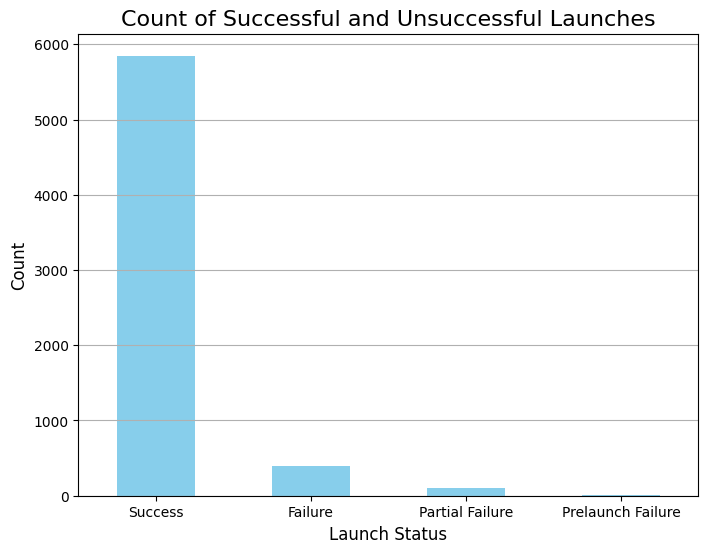

In [4]:
# Count the number of successful and unsuccessful launches
status_counts = launch_data['Launch Status'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## Following the first question: does the price influence the success of a Launch?

### Let's follow a Hypothesis Testing.

### Hypothesis
1) Null Hypothesis (Ho): Price has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): Price influences the success of a launch.

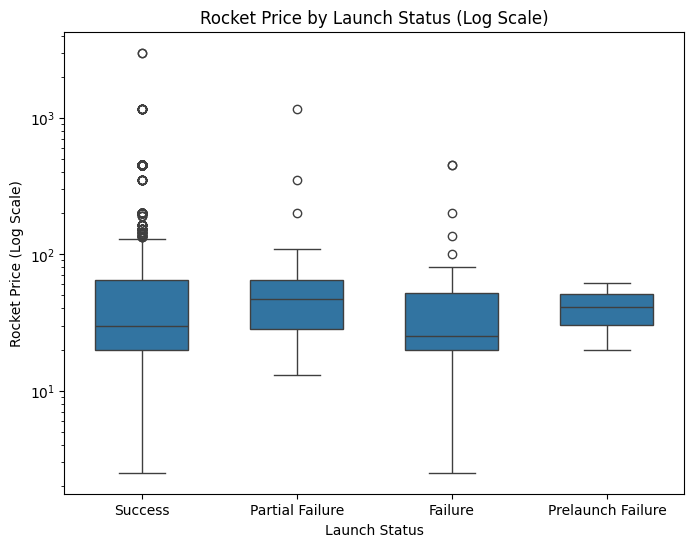

In [6]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(x='Launch Status', y='Rocket Price', data=launch_data, width=0.6)
plt.yscale('log') 
plt.title('Rocket Price by Launch Status (Log Scale)')
plt.xlabel('Launch Status')
plt.ylabel('Rocket Price (Log Scale)')
plt.show()

In [22]:
# Drop rows where Rocket Price or Success_Binary are NaN or infinite
import numpy as np
import statsmodels.api as sm

launch_data['Success_Binary'] = (launch_data['Launch Status'] == 'Success').astype(int)
launch_data = launch_data.replace([np.inf, -np.inf], np.nan)
launch_data = launch_data.dropna(subset=['Rocket Price', 'Success_Binary'])

# Redefine X and y
X = launch_data[['Rocket Price']]
X = sm.add_constant(X)
y = launch_data['Success_Binary']

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.186738
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Success_Binary   No. Observations:                 2272
Model:                          Logit   Df Residuals:                     2270
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                0.002552
Time:                        22:57:10   Log-Likelihood:                -424.27
converged:                       True   LL-Null:                       -425.35
Covariance Type:            nonrobust   LLR p-value:                    0.1407
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.9376      0.117     25.018      0.000       2.708       3.168
Rocket Price     0.0013

In [35]:
### Alternative Questions: What Causes Failure?

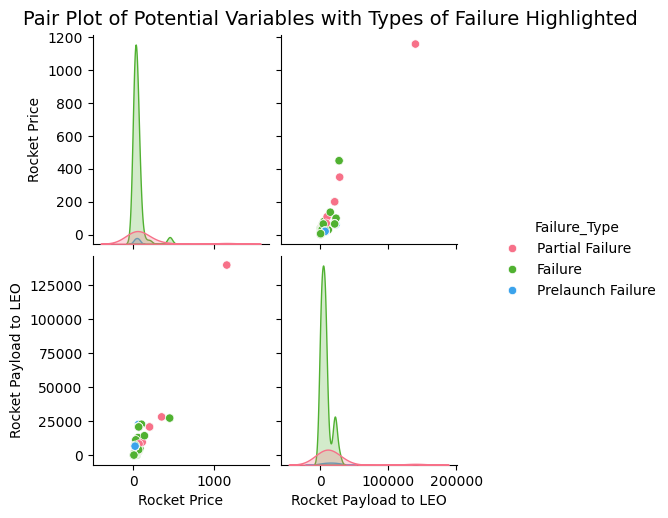

In [20]:
# Create a column for different failure types (ignoring 'Success')
failure_types = ['Partial Failure', 'Failure', 'Prelaunch Failure']
launch_data['Failure_Type'] = launch_data['Launch Status'].apply(
    lambda x: x if x in failure_types else np.nan
)

# Select numerical features for the pair plot, including failure types
selected_features = [
    'Rocket Price',
    'Rocket Payload to LEO',
    'Failure_Type'
]

# Filter only rows with failure types and clean numeric data
failure_data = launch_data[selected_features].dropna(subset=['Failure_Type'])
failure_data = failure_data.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Create a pair plot with different types of failures as hue
sns.pairplot(
    failure_data, 
    hue='Failure_Type', 
    palette='husl', 
    diag_kind='kde'
)
plt.suptitle("Pair Plot of Potential Variables with Types of Failure Highlighted", y=1.02, fontsize=14)
plt.show()